In [128]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [129]:
df = pd.read_stata("data_netbig5_complete.dta")

In [130]:
col_int = ["school","class_id","source_id","target_id","source_fem","give",
           's_big5_E', 's_big5_A', 's_big5_C','s_big5_EI', 's_big5_IO',"recip"]
df_int = df[col_int]
df_int = df_int[df_int["give"] > 0]

In [131]:
graphs = []
for i,clase in enumerate(df["class_id"].unique()):
    attr_col = ["source_id","source_fem",'s_big5_E', 's_big5_A', 's_big5_C','s_big5_EI', 's_big5_IO']
    node_attr = df_int[attr_col].drop_duplicates().set_index('source_id').to_dict('index')
    graphs.append(nx.from_pandas_edgelist(df_int[df_int["class_id"] == clase],
                                          source = "source_id",
                                          target="target_id",
                                          edge_attr="give",
                                          create_using=nx.DiGraph()))
    
    nx.set_node_attributes(graphs[i], node_attr)
    
                 

In [132]:
df_int

school  class_id  source_id  target_id  source_fem  give  s_big5_E  \
3          9        11     1103.0     1101.0         1.0   1.0      34.0   
4          9        11     1113.0     1101.0         1.0   3.0      34.0   
6          9        11     1227.0     1101.0         1.0   1.0      37.0   
7          9        11     1119.0     1101.0         0.0   1.0      26.0   
9          9        11     1102.0     1101.0         0.0   2.0      37.0   
...      ...       ...        ...        ...         ...   ...       ...   
7024       7        55     5502.0     5519.0         1.0   3.0      23.0   
7026       7        55     5515.0     5519.0         1.0   1.0      34.0   
7028       7        55     5514.0     5519.0         1.0   1.0      32.0   
7030       7        55     5518.0     5519.0         1.0   3.0      33.0   
7031       7        55     5513.0     5519.0         1.0   1.0      22.0   

      s_big5_A  s_big5_C  s_big5_EI  s_big5_IO  recip  
3         33.0      31.0       27.0       33.0    1.0  
4         33.0      28.0       33.0       34.0    0.0  
6         31.0      25.0       26.0       35.0   -1.0  
7         23.0      29.0       27.0       30.0   -2.0  
9         33.0      32.0       23.0       37.0    1.0  
...        ...       ...        ...        ...    ...  
7024      38.0      34.0       30.0       32.0    0.0  
7026      37.0      29.0       34.0       34.0    0.0  
7028      32.0      23.0       31.0       27.0    0.0  
7030      39.0      35.0       18.0       39.0    0.0  
7031      28.0      23.0       25.0       22.0    0.0  

[5038 rows x 12 columns]

### Chech graphs visually 

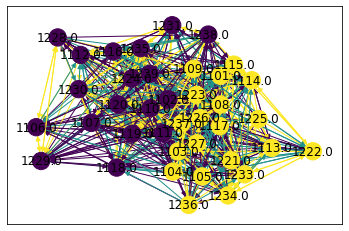

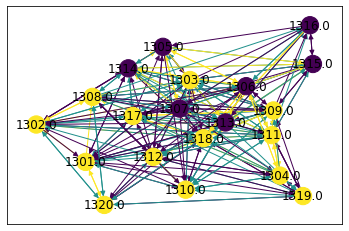

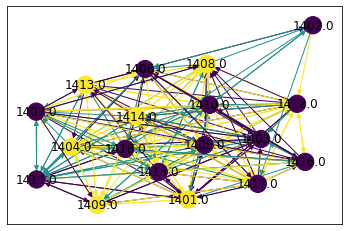

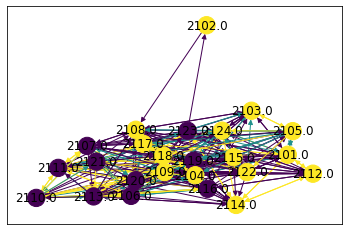

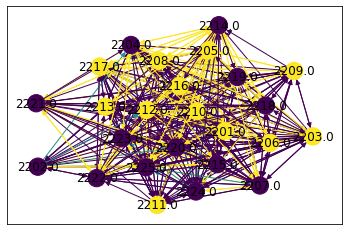

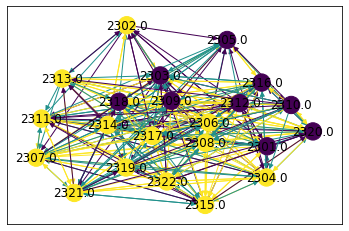

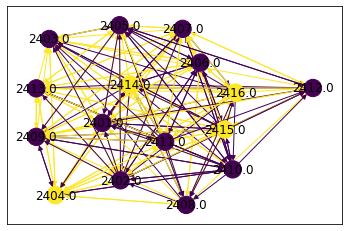

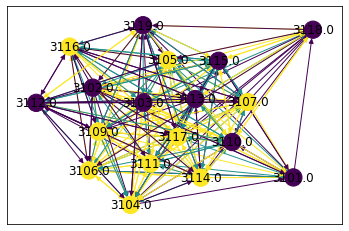

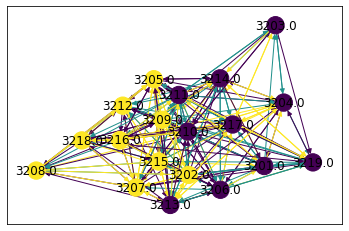

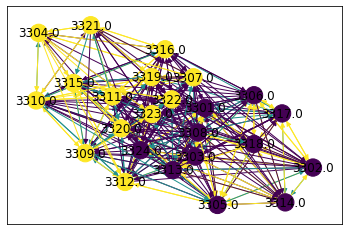

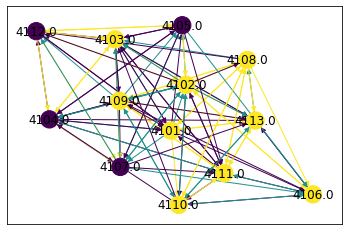

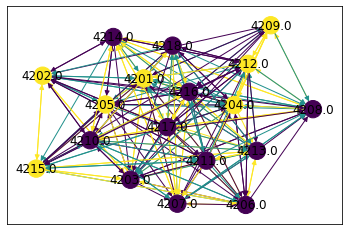

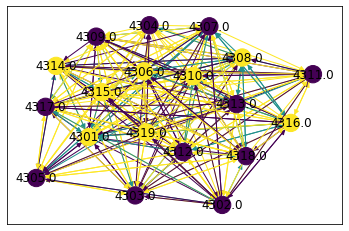

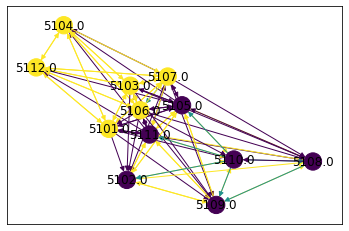

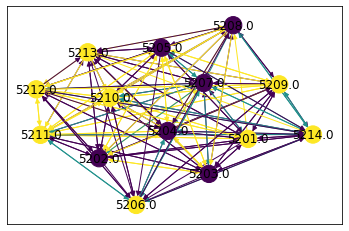

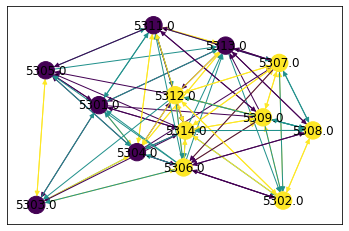

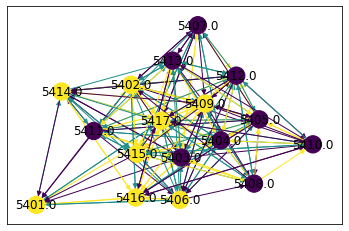

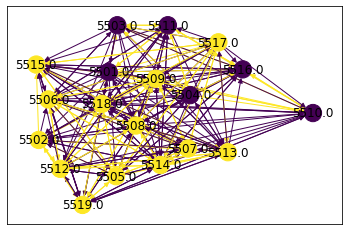

In [133]:
for graph in graphs:
    plt.figure()
    nx.draw_networkx(graph,
                     node_color = [node[1]["source_fem"] for node in graph.nodes(data=True)],
                     edge_color = [w["give"] for u,v,w in graph.edges(data=True)])

## Elaborate total dataframe

In [134]:
from sklearn.preprocessing import MinMaxScaler

In [247]:
#betweenness,eigenvectorcentrality,clustering, assortativity
total_df = pd.DataFrame()
for graph in graphs:
    mes_1 = pd.DataFrame.from_dict(nx.betweenness_centrality(graph,weight="give"),orient="index")
    mes_2 = pd.DataFrame.from_dict(nx.eigenvector_centrality(graph,weight="give"),orient="index")
    mes_3 = pd.DataFrame.from_dict(nx.clustering(graph,weight="give"),orient="index")
    mes_4 = pd.DataFrame.from_dict(nx.average_neighbor_degree(graph,source='out',target='out',weight="give"),orient="index")
    cross_sex_f = []
    for node in graph.nodes():
        cross_sex_n = []
        neighbors = graph.neighbors(node)
        for neigh in neighbors:
            cross_sex_n.append(nx.get_node_attributes(graph,"source_fem")[neigh])
        cross_sex_f.append(sum(cross_sex_n))
    mes_5 = pd.DataFrame(cross_sex_f,index = mes_1.index)
    mes_6 = pd.DataFrame.from_dict(nx.in_degree_centrality(graph),orient="index")
    mes_7 = pd.DataFrame.from_dict(nx.out_degree_centrality(graph),orient="index")
    mes_8 = pd.DataFrame.from_dict(dict(graph.degree(weight="give")),orient="index")
    
    all_measures =  pd.concat([mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8],axis=1,)
    node_attrs = pd.DataFrame([node[1].values() for node in graph.nodes(data=True)],columns = attr_col[1:],index=mes_1.index)
    pre_total_df = pd.concat([all_measures,node_attrs],axis=1)
    total_df =  pd.concat([pre_total_df,total_df],axis=0)

columns_df = ["betw","eigen","clust","assort","cross_sex_f","in_degree","out_degree","total_degree"]
columns_df.extend(node_attrs.columns)
total_df.columns = columns_df
total_df.dropna(inplace=True)

In [251]:
total_df.describe()

betw       eigen       clust      assort  cross_sex_f  \
count  322.000000  322.000000  322.000000  322.000000   322.000000   
mean     0.034810    0.211493    0.487729   15.102932     7.391304   
std      0.032464    0.070029    0.089717    3.735803     3.762703   
min      0.000000    0.002641    0.166667    6.900000     0.000000   
25%      0.014152    0.166390    0.422837   12.772381     5.000000   
50%      0.025499    0.212520    0.473149   14.274295     7.000000   
75%      0.046213    0.266482    0.559775   16.188462    10.000000   
max      0.207232    0.431730    0.746913   24.344828    19.000000   

        in_degree  out_degree  total_degree  source_fem    s_big5_E  \
count  322.000000  322.000000    322.000000  322.000000  322.000000   
mean     0.727094    0.727288     58.077640    0.509317   31.126294   
std      0.176521    0.196634     20.320873    0.500691    3.623783   
min      0.043478    0.043478      2.000000    0.000000   17.000000   
25%      0.613095    0.594595     43.250000    0.000000   29.000000   
50%      0.750000    0.750000     56.000000    1.000000   32.000000   
75%      0.869565    0.882353     69.000000    1.000000   34.000000   
max      1.000000    1.000000    143.000000    1.000000   38.000000   

         s_big5_A    s_big5_C   s_big5_EI   s_big5_IO  
count  322.000000  322.000000  322.000000  322.000000  
mean    30.698758   29.067029   24.345238   29.031056  
std      4.403179    4.661640    4.891974    4.472149  
min     17.000000   15.000000   14.000000   17.000000  
25%     28.000000   26.000000   21.000000   26.000000  
50%     31.000000   29.625000   24.000000   29.000000  
75%     34.000000   33.000000   28.000000   32.000000  
max     39.000000   39.000000   38.000000   39.000000

In [137]:
#sc_big5 = MinMaxScaler()
cols_regression = ["source_fem","s_big5_E","s_big5_A","s_big5_C","s_big5_EI","s_big5_IO"]
for col in cols_regression:
    total_df[col] = total_df[col].apply(lambda x:np.round(x))
    total_df["source_fem"] = total_df["source_fem"].apply(lambda x:int(x))
total_df["source_fem"] = total_df["source_fem"].astype("category")
#sc_big5.fit(total_df[cols_regression][1:])
#total_df[cols_regression[1:]] = sc.transform(total_df[cols_regression])
sc = MinMaxScaler()
sc.fit(total_df.drop("source_fem",axis=1))
col_transform = list(total_df.columns)
col_transform.remove("source_fem")
total_df[col_transform] = sc.transform(total_df[col_transform])

In [138]:
total_df

betw     eigen     clust    assort  cross_sex_f  in_degree  \
5518.0  0.442757  0.653432  0.355237  0.378336     0.631579   1.000000   
5501.0  0.110258  0.402183  0.378413  0.355406     0.684211   0.593434   
5519.0  0.165060  0.467533  0.447432  0.418462     0.526316   0.651515   
5503.0  0.131679  0.282356  0.412906  0.316487     0.421053   0.419192   
5514.0  0.290049  0.662572  0.375431  0.364005     0.631579   0.941919   
...          ...       ...       ...       ...          ...        ...   
1233.0  0.055506  0.407409  0.475744  0.895067     0.684211   0.689189   
1236.0  0.020631  0.085409  0.482249  0.922910     0.736842   0.208845   
1106.0  0.042959  0.214914  0.334193  0.540752     0.052632   0.434889   
1228.0  0.051960  0.201632  0.357169  0.515275     0.105263   0.378378   
1229.0  0.072886  0.291386  0.327794  0.534873     0.000000   0.576167   

        out_degree  total_degree source_fem  s_big5_E  s_big5_A  s_big5_C  \
5518.0    1.000000      0.411348          1  0.761905  1.000000  0.833333   
5501.0    1.000000      0.347518          0  0.571429  0.818182  0.500000   
5519.0    0.651515      0.269504          1  0.523810  0.500000  0.875000   
5503.0    0.709596      0.234043          0  0.238095  0.454545  0.166667   
5514.0    0.883838      0.361702          1  0.714286  0.681818  0.333333   
...            ...           ...        ...       ...       ...       ...   
1233.0    0.434889      0.617021          1  0.666667  0.545455  0.791667   
1236.0    0.491400      0.375887          1  0.476190  0.681818  0.750000   
1106.0    0.180590      0.283688          0  0.619048  0.454545  0.500000   
1228.0    0.208845      0.304965          0  0.714286  0.772727  0.500000   
1229.0    0.180590      0.333333          0  0.476190  0.500000  0.500000   

        s_big5_EI  s_big5_IO  
5518.0   0.166667   1.000000  
5501.0   0.458333   0.318182  
5519.0   0.166667   0.636364  
5503.0   0.458333   0.000000  
5514.0   0.708333   0.454545  
...           ...        ...  
1233.0   0.250000   0.545455  
1236.0   0.291667   0.500000  
1106.0   0.791667   0.681818  
1228.0   0.083333   0.636364  
1229.0   0.375000   0.681818  

[322 rows x 14 columns]

In [250]:
total_df.to_stata('data_netbig5_nodes.dta') 

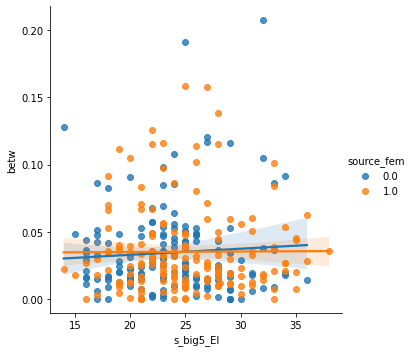

In [249]:
sns.lmplot(data=total_df, x= "s_big5_EI",y="betw",hue="source_fem")

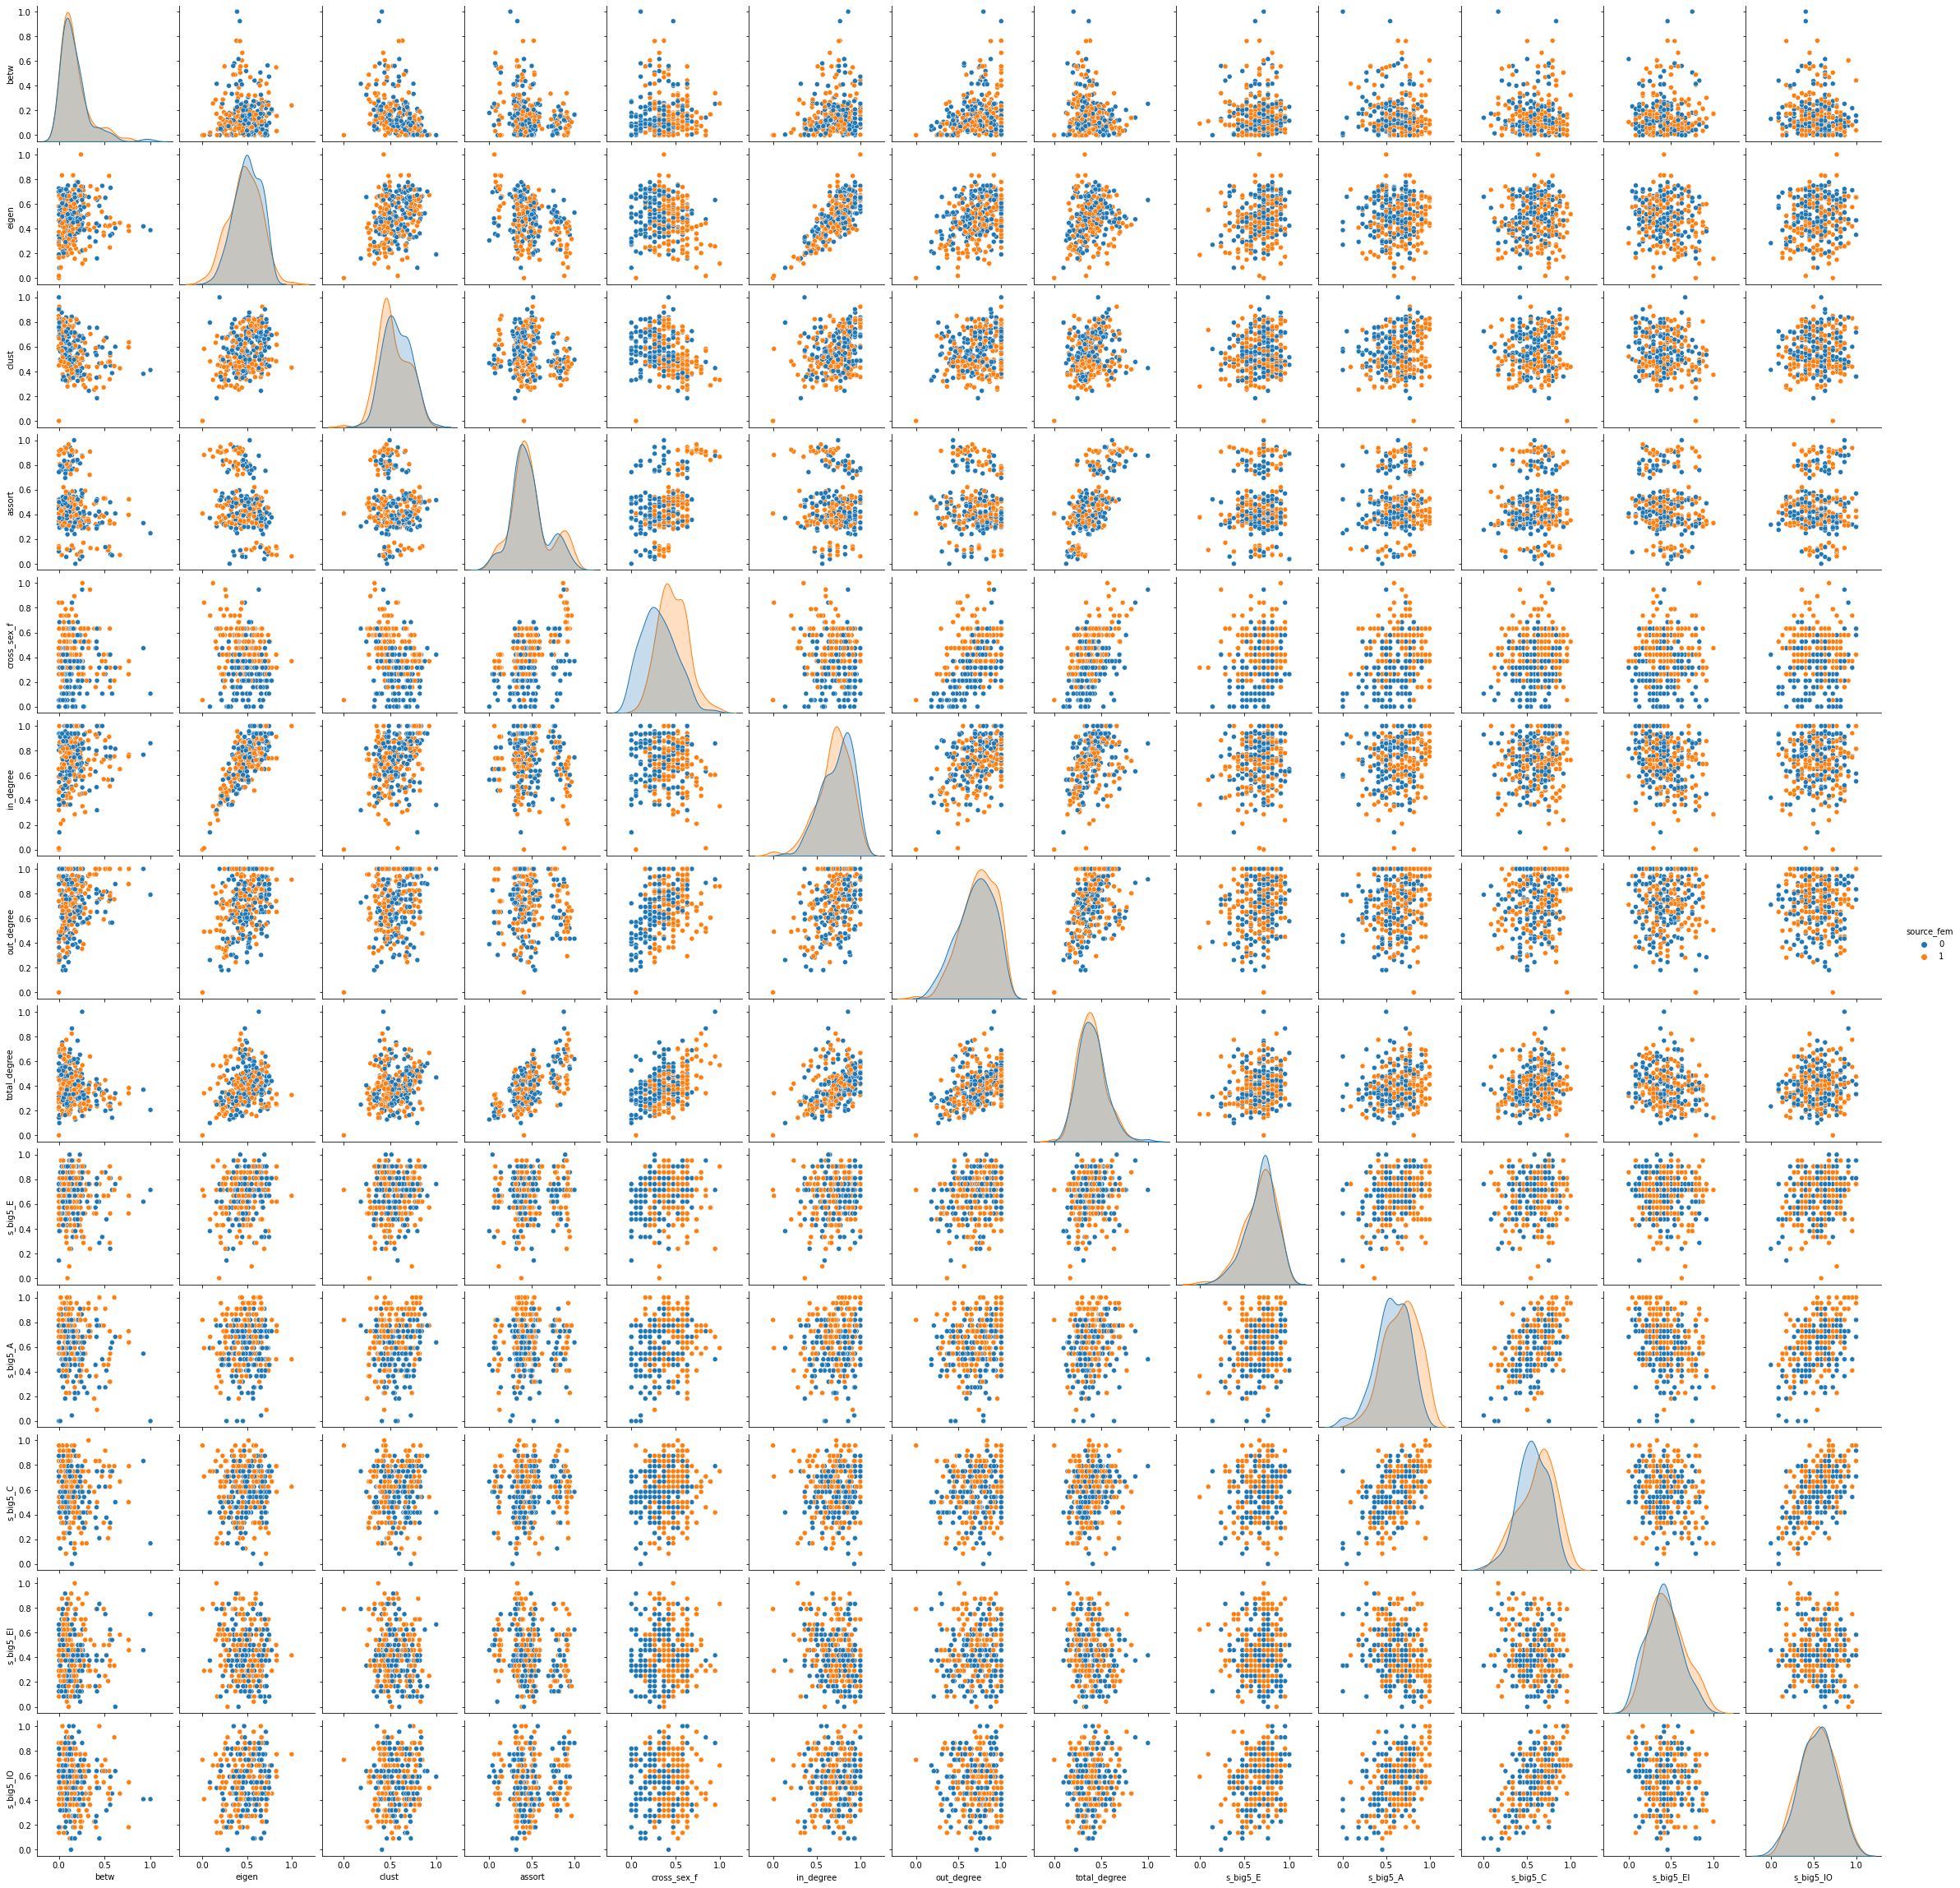

In [139]:
sns.pairplot(total_df[total_df.columns],hue="source_fem")

## Regressions on structural measures to predict Big5

-Linear regression, gaussian process, SVR, neural network, ensemble methods 

In [140]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [141]:
target_variable = "s_big5_EI"
len_measures = 8

X = total_df[total_df.columns[:len_measures+1]].values
y = total_df[target_variable].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [142]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 
grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=0)
grid.fit(X_train,y_train)


GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [143]:
grid.best_params_
grid.best_estimator_

SVR(C=1, gamma=0.1)

In [144]:
grid.score(X_test,y_test)

-0.05551388909100785

Text(0.5, 1.0, 'MSE sqrt:0.19653237094689843')

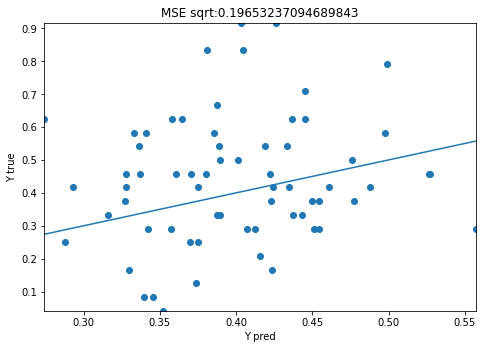

In [145]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.scatter(grid.predict(X_test),y_test)
x = np.linspace(grid.predict(X_test).min(),grid.predict(X_test).max(),30)
plt.plot(x,x)
ax.set_xlim([grid.predict(X_test).min(),grid.predict(X_test).max()])
ax.set_ylim([y_test.min(),y_test.max()])
ax.set_xlabel("Y pred")
ax.set_ylabel("Y true")
ax.set_title("MSE sqrt:"+str(np.sqrt(mean_squared_error(y_test,grid.predict(X_test)))) )

Gaussian process regression

In [146]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel,RBF
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X_train, y_train)
gpr.score(X_test, y_test)



-0.03223730007470893

Text(0.5, 1.0, 'MSE sqrt:0.19435328762659104')

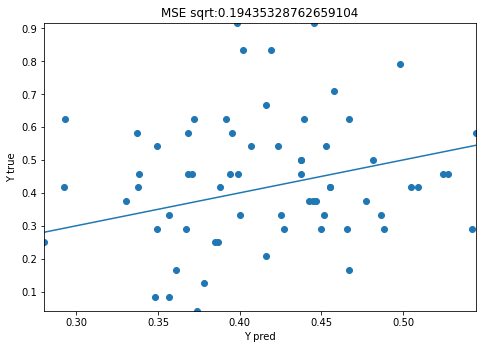

In [147]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.scatter(gpr.predict(X_test),y_test)
x = np.linspace(gpr.predict(X_test).min(),gpr.predict(X_test).max(),30)
plt.plot(x,x)
ax.set_xlim([gpr.predict(X_test).min(),gpr.predict(X_test).max()])
ax.set_ylim([y_test.min(),y_test.max()])
ax.set_xlabel("Y pred")
ax.set_ylabel("Y true")
ax.set_title("MSE sqrt:"+str(np.sqrt(mean_squared_error(y_test,gpr.predict(X_test)))) )

Linear regression

In [148]:
from sklearn.linear_model import LinearRegression

In [149]:
linear_model = LinearRegression()
linear_model.fit(X_train,y_train)

LinearRegression()

Text(0.5, 1.0, 'MSE sqrt:0.1941126679678208')

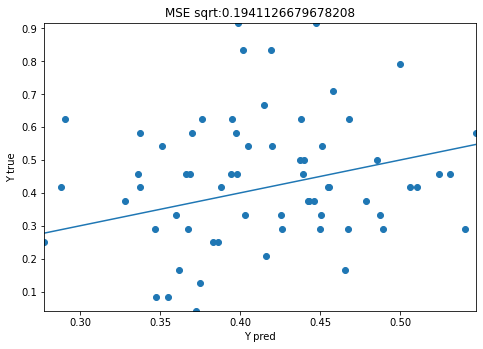

In [150]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.scatter(linear_model.predict(X_test),y_test)
x = np.linspace(linear_model.predict(X_test).min(),linear_model.predict(X_test).max(),30)
plt.plot(x,x)
ax.set_xlim([linear_model.predict(X_test).min(),linear_model.predict(X_test).max()])
ax.set_ylim([y_test.min(),y_test.max()])
ax.set_xlabel("Y pred")
ax.set_ylabel("Y true")
ax.set_title("MSE sqrt:"+str(np.sqrt(mean_squared_error(y_test,linear_model.predict(X_test)))) )

In [151]:
linear_model.score(X_test,y_test)

-0.029682953418024516

In [152]:
linear_model.coef_

array([-0.04290784, -0.06294001, -0.13503528, -0.22404322,  0.05253873,
       -0.23192978,  0.09117511,  0.11739091,  0.02719433])

Neural network

In [153]:
import tensorflow as tf

In [173]:
neural_regressor = tf.keras.Sequential([
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(16,activation="relu"),
    tf.keras.layers.Dense(16,activation="relu"),
    tf.keras.layers.Dense(1)
])

neural_regressor.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss=tf.keras.losses.mean_squared_error,
                        metrics="mae")

In [174]:
neural_regressor.fit(X_train,y_train,epochs=400)

Epoch 1/400
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
9/9 [==============================] - 0s 742us/step - loss: 0.0930 - mae: 0.2442
Epoch 2/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0519 - mae: 0.1826
Epoch 3/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0561 - mae: 0.1945
Epoch 4/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0513 - mae: 0.1855
Epoch 5/400
9/9 [=======

9/9 [==============================] - 0s 2ms/step - loss: 0.0386 - mae: 0.1573
Epoch 80/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0399 - mae: 0.1596
Epoch 81/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0406 - mae: 0.1601
Epoch 82/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0393 - mae: 0.1604
Epoch 83/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0388 - mae: 0.1588
Epoch 84/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0388 - mae: 0.1575
Epoch 85/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0388 - mae: 0.1569
Epoch 86/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0382 - mae: 0.1564
Epoch 87/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0384 - mae: 0.1578
Epoch 88/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0384 - mae: 0.1579
Epoch 89/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0386 - ma

9/9 [==============================] - 0s 2ms/step - loss: 0.0362 - mae: 0.1521
Epoch 167/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0371 - mae: 0.1539
Epoch 168/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0394 - mae: 0.1583
Epoch 169/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0378 - mae: 0.1571
Epoch 170/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0360 - mae: 0.1511
Epoch 171/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0369 - mae: 0.1536
Epoch 172/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0366 - mae: 0.1520
Epoch 173/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0363 - mae: 0.1519
Epoch 174/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0358 - mae: 0.1517
Epoch 175/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0355 - mae: 0.1516
Epoch 176/400
9/9 [==============================] - 0s 1ms/step - loss: 0

9/9 [==============================] - 0s 2ms/step - loss: 0.0347 - mae: 0.1494
Epoch 254/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0343 - mae: 0.1480
Epoch 255/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0346 - mae: 0.1491
Epoch 256/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0350 - mae: 0.1493
Epoch 257/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0352 - mae: 0.1502
Epoch 258/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0341 - mae: 0.1477
Epoch 259/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0348 - mae: 0.1505
Epoch 260/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0342 - mae: 0.1498
Epoch 261/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0340 - mae: 0.1475
Epoch 262/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0338 - mae: 0.1466
Epoch 263/400
9/9 [==============================] - 0s 2ms/step - loss: 0

9/9 [==============================] - 0s 2ms/step - loss: 0.0328 - mae: 0.1442
Epoch 341/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0325 - mae: 0.1430
Epoch 342/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0322 - mae: 0.1427
Epoch 343/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0326 - mae: 0.1432
Epoch 344/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0324 - mae: 0.1412
Epoch 345/400
9/9 [==============================] - 0s 2ms/step - loss: 0.0341 - mae: 0.1459
Epoch 346/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0333 - mae: 0.1444
Epoch 347/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0323 - mae: 0.1418
Epoch 348/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0337 - mae: 0.1447
Epoch 349/400
9/9 [==============================] - 0s 1ms/step - loss: 0.0328 - mae: 0.1430
Epoch 350/400
9/9 [==============================] - 0s 1ms/step - loss: 0

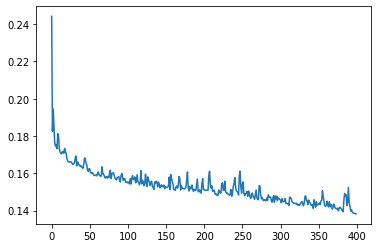

In [175]:
plt.plot(neural_regressor.history.history["mae"])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Text(0.5, 1.0, 'MSE sqrt:0.22155264037075217')

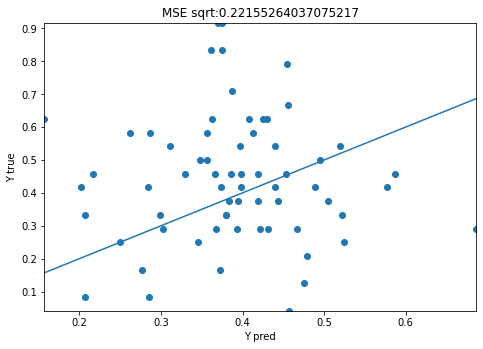

In [176]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.scatter(neural_regressor.predict(X_test),y_test)
x = np.linspace(neural_regressor.predict(X_test).min(),neural_regressor.predict(X_test).max(),30)
plt.plot(x,x)
ax.set_xlim([neural_regressor.predict(X_test).min(),neural_regressor.predict(X_test).max()])
ax.set_ylim([y_test.min(),y_test.max()])
ax.set_xlabel("Y pred")
ax.set_ylabel("Y true")
ax.set_title("MSE sqrt:"+str(np.sqrt(mean_squared_error(y_test,neural_regressor.predict(X_test)))) )

Ensemble methods

In [158]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor



# Training classifiers
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg = ereg.fit(X_train, y_train)

Text(0.5, 1.0, 'MSE sqrt:0.19729956373739288')

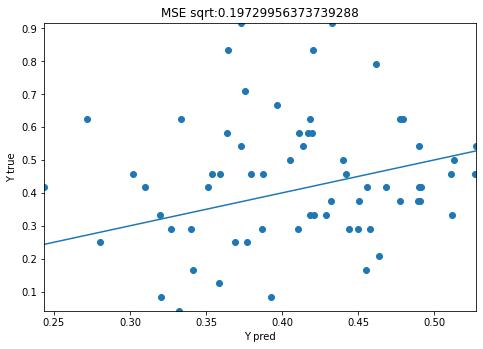

In [159]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.scatter(ereg.predict(X_test),y_test)
x = np.linspace(ereg.predict(X_test).min(),ereg.predict(X_test).max(),30)
plt.plot(x,x)
ax.set_xlim([ereg.predict(X_test).min(),ereg.predict(X_test).max()])
ax.set_ylim([y_test.min(),y_test.max()])
ax.set_xlabel("Y pred")
ax.set_ylabel("Y true")
ax.set_title("MSE sqrt:"+str(np.sqrt(mean_squared_error(y_test,ereg.predict(X_test)))))

In [160]:
ereg.score(X_test,y_test)

-0.06377067848844287

KNN neighbors regression (perhaps try KNN to form groups and analyze it) 

In [161]:
from sklearn.neighbors import KNeighborsRegressor

In [162]:
knn = KNeighborsRegressor(n_neighbors=15)
knn.fit(X_train,y_train)


KNeighborsRegressor(n_neighbors=15)

Text(0.5, 1.0, 'MSE sqrt:0.19941896844648027')

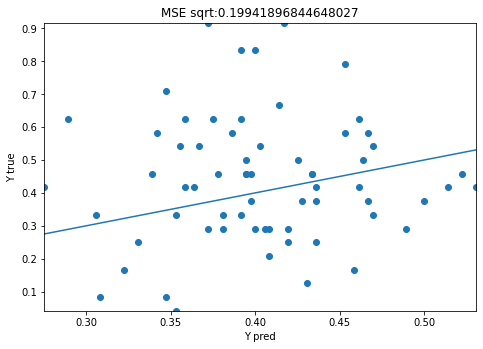

In [163]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.scatter(knn.predict(X_test),y_test)
x = np.linspace(knn.predict(X_test).min(),knn.predict(X_test).max(),30)
plt.plot(x,x)
ax.set_xlim([knn.predict(X_test).min(),knn.predict(X_test).max()])
ax.set_ylim([y_test.min(),y_test.max()])
ax.set_xlabel("Y pred")
ax.set_ylabel("Y true")
ax.set_title("MSE sqrt:"+str(np.sqrt(mean_squared_error(y_test,knn.predict(X_test)))))

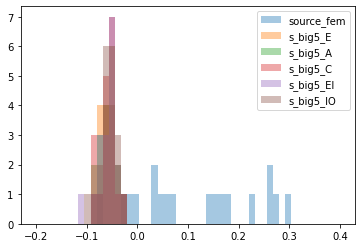

In [164]:
for attr in attr_col[1:]:
    sex_assort = []
    for graph in graphs:
        sex_assort.append(nx.attribute_assortativity_coefficient(graph,attr))
    plt.hist(sex_assort,bins=50,label=attr,alpha=0.4,range=(-0.2,0.4))
    plt.legend()

Reconsider analysis separating boys and girls subgraphs

In [165]:
graphs_boys = []
graphs_girls = []
for graph in graphs: 
    girls = [node[0] for node in graph.nodes(data=True) if node[1]["source_fem"] == 1.0]
    boys = [node[0] for node in graph.nodes(data=True) if node[1]["source_fem"] == 0.0]
    graphs_boys.append(graph.subgraph(boys))
    graphs_girls.append(graph.subgraph(boys))

In [166]:
total_df_boys = total_df[total_df["source_fem"] == 0.0]
total_df_girls = total_df[total_df["source_fem"] == 1.0]

dyadic

In [398]:
cols_int = ["source_id","target_id","source_fem","target_fem",
           'distance_E', 'distance_A', 'distance_C',
       'distance_EI', 'distance_IO', 'distance_big5',"give","receive",'recip']

df_dyadic = df[cols_int]
df_dyadic.dropna(inplace=True)
sc_dyadic = MinMaxScaler()
sc_dyadic.fit(df_dyadic[df_dyadic.columns[4:-1]])
df_dyadic[df_dyadic.columns[4:-1]] = sc_dyadic.transform(df_dyadic[df_dyadic.columns[4:-1]])
df_dyadic.drop(["source_id","target_id"],axis=1,inplace=True)
#df_dyadic["recip"] = df_dyadic["recip"].apply(lambda x: int(x+3))

/home/juan/.local/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/juan/.local/lib/python3.8/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/home/juan/.local/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [399]:
cols_int = ["source_id","target_id","source_fem","target_fem","give","receive",
           's_big5_E', 's_big5_A', 's_big5_C','s_big5_EI', 's_big5_IO', 
            't_big5_E', 't_big5_A', 't_big5_C','t_big5_EI', 't_big5_IO']
df_dyadic = df[cols_int].dropna().copy()

In [400]:
df_dyadic["extra_target"] = df_dyadic.apply(lambda x: min(x.source_id,x.target_id),axis=1)

In [401]:
distance = lambda x,y: np.abs(x-y)
def distance_global(a,b,c,d,e):
    return np.sqrt(a**2+b**2+c**2+d**2+e**2)

df_dyadic['distance_E'] = df_dyadic.apply(lambda x: distance(x.s_big5_E, x.t_big5_E), axis=1)
df_dyadic['distance_A'] = df_dyadic.apply(lambda x: distance(x.s_big5_A, x.t_big5_A), axis=1)
df_dyadic['distance_C'] = df_dyadic.apply(lambda x: distance(x.s_big5_C, x.t_big5_C), axis=1)
df_dyadic['distance_EI'] = df_dyadic.apply(lambda x: distance(x.s_big5_EI, x.t_big5_EI), axis=1)
df_dyadic['distance_IO'] = df_dyadic.apply(lambda x: distance(x.s_big5_IO, x.t_big5_IO), axis=1)
df_dyadic['distance_big5'] = df_dyadic.apply(lambda x: distance_global(x.distance_E,x.distance_A,x.distance_C,x.distance_EI,x.distance_IO),axis=1)
df_dyadic['recip'] = df_dyadic.apply(lambda x: distance(x.give,x.receive),axis=1)

In [413]:
df_relationships = df_dyadic.drop_duplicates(["source_id","extra_target"]).drop(["extra_target"],axis=1)
df_relationships.drop(["source_id","target_id",'s_big5_E', 's_big5_A', 's_big5_C', 's_big5_EI', 's_big5_IO',
       't_big5_E', 't_big5_A', 't_big5_C', 't_big5_EI', 't_big5_IO'],axis=1,inplace=True)
df_relationships["max_rel"] = df_relationships.apply(lambda x:max(x.give,x.receive),axis=1)

In [414]:
df_relationships.columns

Index(['source_fem', 'target_fem', 'give', 'receive', 'distance_E',
       'distance_A', 'distance_C', 'distance_EI', 'distance_IO',
       'distance_big5', 'recip', 'max_rel'],
      dtype='object')

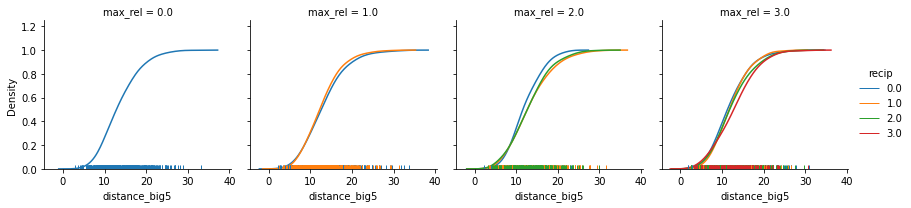

In [438]:
g = sns.FacetGrid(df_relationships,  col="max_rel",hue="recip",)
g.map(sns.kdeplot, "distance_big5",cumulative=True)
g.map(sns.rugplot, "distance_big5")
g.add_legend()

<AxesSubplot:>

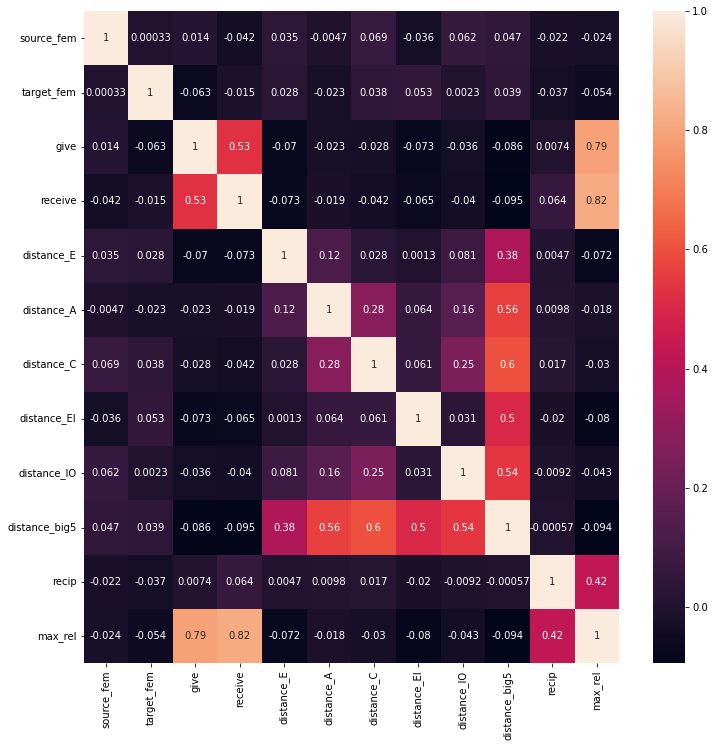

In [450]:
fig = plt.figure(figsize=(12,12))
sns.heatmap(df_relationships.corr(),annot=True,fmt=".2g",)


In [223]:
target_variable = "recip"
len_measures = 8

X = df_dyadic[df_dyadic.columns[2:-1]].values
y = df_dyadic[target_variable].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [231]:
neural_regressor = tf.keras.Sequential([
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(16,activation="relu"),
    tf.keras.layers.Dense(16,activation="relu"),
    tf.keras.layers.Dense(7,activation="softmax")
])

neural_regressor.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics=["accuracy"])

In [232]:
neural_regressor.fit(X_train,y_train,epochs=100)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
168/168 [==============================] - 0s 672us/step - loss: 1.5951 - accuracy: 0.4948
Epoch 2/100
168/168 [==============================] - 0s 836us/step - loss: 1.4707 - accuracy: 0.5071
Epoch 3/100
168/168 [==============================] - 0s 860us/step - loss: 1.4637 - accuracy: 0.5071
Epoch 4/100
168/168 [==============================] - 0s 769us/step - loss: 1.4598 -

168/168 [==============================] - 0s 738us/step - loss: 1.4368 - accuracy: 0.5069
Epoch 72/100
168/168 [==============================] - 0s 694us/step - loss: 1.4364 - accuracy: 0.5073
Epoch 73/100
168/168 [==============================] - 0s 712us/step - loss: 1.4361 - accuracy: 0.5075
Epoch 74/100
168/168 [==============================] - 0s 803us/step - loss: 1.4366 - accuracy: 0.5080
Epoch 75/100
168/168 [==============================] - 0s 825us/step - loss: 1.4351 - accuracy: 0.5065
Epoch 76/100
168/168 [==============================] - 0s 786us/step - loss: 1.4352 - accuracy: 0.5071
Epoch 77/100
168/168 [==============================] - 0s 809us/step - loss: 1.4354 - accuracy: 0.5071
Epoch 78/100
168/168 [==============================] - 0s 790us/step - loss: 1.4348 - accuracy: 0.5075
Epoch 79/100
168/168 [==============================] - 0s 813us/step - loss: 1.4348 - accuracy: 0.5077
Epoch 80/100
168/168 [==============================] - 0s 732us/step - loss:

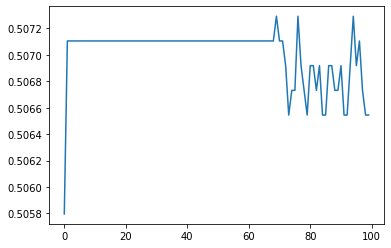

In [226]:
plt.plot(neural_regressor.history.history["accuracy"]
)

In [233]:
from sklearn.metrics import confusion_matrix

In [234]:
confusion_matrix(y_test,neural_regressor.predict(
))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [ ]:
neural_regressor